# Model Development

This notebook demonstrates how to load models and datasets for model development. Note that this notebook is used for demonstration and debugging purposes only. 

For the actual model training, run `python src/train_cnn.py`:
```s
usage: train_cnn.py [-h] [--cnn_config CNN_CONFIG] [--lr_finder LR_FINDER] [--iso ISO [ISO ...]]

Model Training
options:
  -h, --help              show this help message and exit
  --cnn_config CNN_CONFIG Path to the configuration file
  --lr_finder LR_FINDER   Learning rate finder (boolean indicator)
  --iso ISO [ISO ...]     ISO 3166-1 alpha-3 codes
```

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import os 
os.chdir('/home/itingzon.unicef/giga')
from utils import cnn_utils
from utils import config_utils

import torchsummary
import torch

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Configuration

In [24]:
iso_code = "SSD"
config_file = "configs/cnn_configs/convnext_small.yaml"

config = config_utils.load_config(os.path.join(os.getcwd(), config_file))
config["iso_codes"] = [iso_code]
data, data_loader, classes = cnn_utils.load_dataset(config, phases=["train", "val", "test"])

INFO:root:Loading existing file: /home/itingzon.unicef/giga/data/vectors/GIGAv1/train/SSD_train.geojson
INFO:root:
  rurban  iso       class  count  percentage
0  rural  SSD  non_school   2358    0.497468
1  rural  SSD      school   1018    0.214768
2  urban  SSD  non_school    802    0.169198
3  urban  SSD      school    562    0.118565
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  SSD non_school test       225    0.474684
                      train     1917         NaN
                      val        216    0.455696
           school     test       112    0.236287
                      train      800         NaN
                      val        106    0.223629
urban  SSD non_school test        78    0.164557
                      train      659         NaN
                      val         65    0.137131
           school     test        58    0.122363
                      train      444         NaN
            

## Visualize Samples

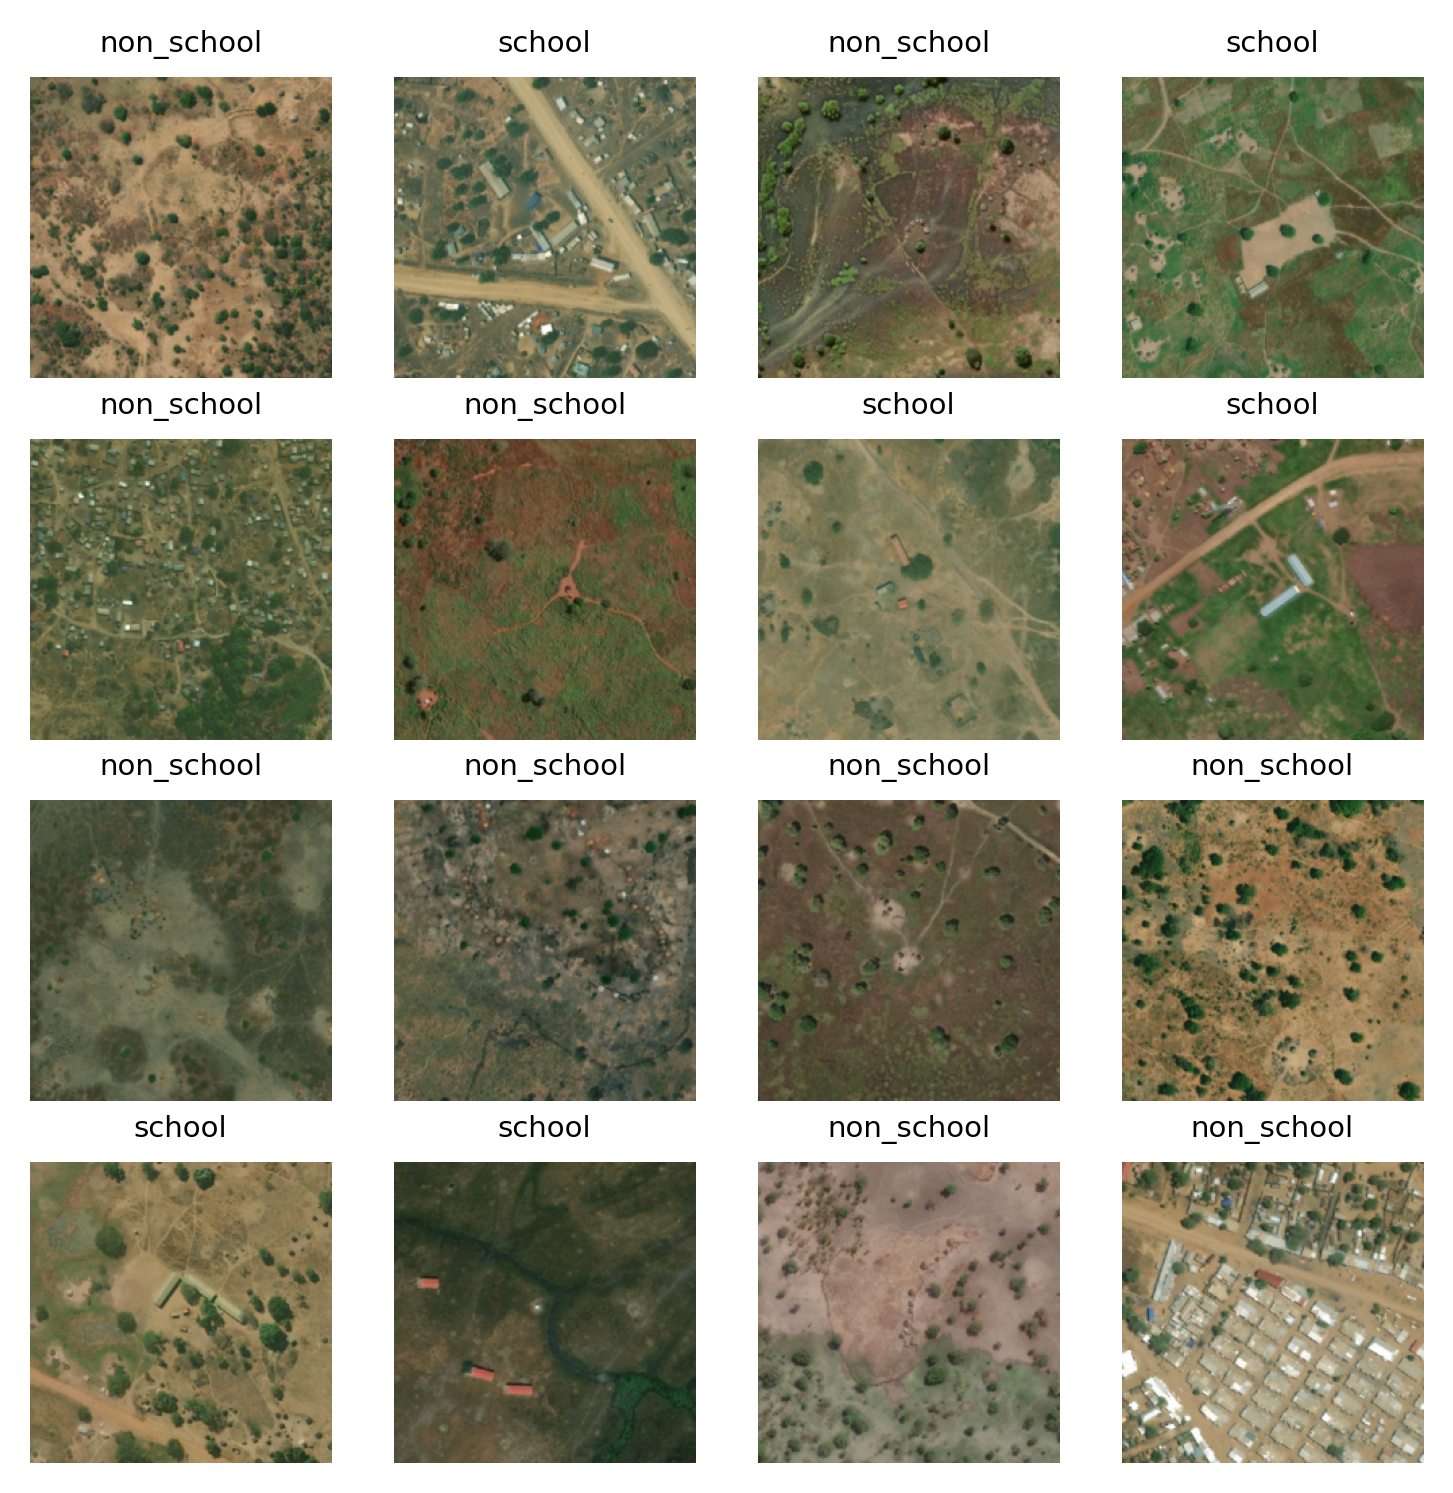

In [25]:
cnn_utils.visualize_data(data, data_loader, phase='train', normalize=config["normalize"])

## Load Model

In [67]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=2,
    data_loader=data_loader,
    model_type=config["model"],
    pretrained=config["pretrained"],
    scheduler_type=config["scheduler"],
    optimizer_type=config["optimizer"],
    label_smoothing=config["label_smoothing"],
    lr=config["lr"],
    patience=config["patience"],
    lr_finder=False,
    device=device
)
#torchsummary.summary(model, (3, 500, 500))
model

DataParallel(
  (module): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,)

## Learning Rate Finder

  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.91E-04


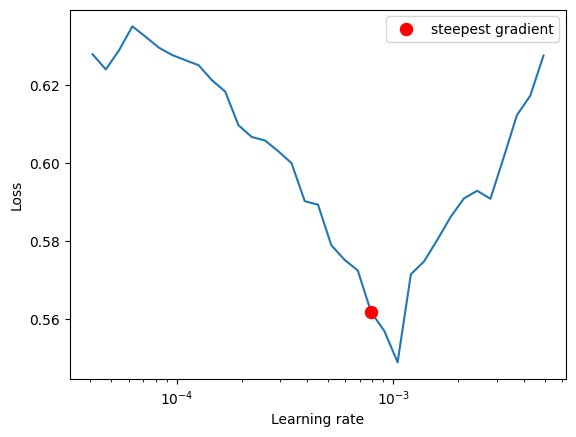

INFO:root:Best lr: 0.0007906043210907702


In [22]:
lr = cnn_utils.run_lr_finder(
    data_loader, 
    model, 
    optimizer, 
    criterion, 
    device,
    start_lr=1e-5,
    end_lr=1e-2, 
    num_iter=50, 
    plot=True
)